<a href="https://colab.research.google.com/github/ManullangJihan/100-Day-ML-Challenge/blob/main/10_Color_Cancer_DeepLarning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download andrewmvd/lung-and-colon-cancer-histopathological-images
!unzip /content/lung-and-colon-cancer-histopathological-images.zip

In [2]:
import time
import copy
import torch
import torch.nn as nn
from torch.optim import SGD
from torch.optim.lr_scheduler import ExponentialLR
from torch.utils.data import Dataset, DataLoader, random_split

import torchvision
from torchvision import models, transforms
from torchvision.datasets import ImageFolder
from tqdm import tqdm

In [3]:
n_channels = 3
n_classes = 5
batch_size = 128
lr = 1e-3
momentum = 0.9
n_epochs = 20

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using: {device} Device")

Using: cuda Device


In [4]:
myTransform = transforms.Compose(
    [transforms.Resize(224),
     transforms.ToTensor(),
     transforms.Normalize([0.5 for _ in range(n_channels)],
                          [0.5 for _ in range(n_channels)])]
)

colon_datasets = ImageFolder(
    "/content/lung_colon_image_set/colon_image_sets", 
    transform = myTransform)

n_samples = len(colon_datasets)
train_size = int(0.6 * n_samples)
test_size = n_samples - train_size
dataset_sizes = {"train":train_size, "eval":test_size}

datasets = dict()
datasets["train"], datasets["eval"] = random_split(
    colon_datasets, 
    [train_size, test_size]
)

data_loaders = {x: DataLoader(datasets[x], batch_size=batch_size, shuffle=True)
                for x in ["train", "eval"]
}

In [27]:
classes = colon_datasets.classes

['colon_aca', 'colon_n']

In [5]:
for X, y in data_loaders["train"]:
    print(f"X shape: {X.shape}")
    print(f"y shape: {y.shape}")
    break

X shape: torch.Size([128, 3, 224, 224])
y shape: torch.Size([128])


In [ ]:
from torchvision.models import ResNet34_Weights

model = models.resnet34(weights=ResNet34_Weights.IMAGENET1K_V1)

In [41]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [7]:
model.fc = nn.Sequential(
    nn.Linear(in_features=512, out_features=n_classes),
    nn.Sigmoid()
)

model = model.to(device)

In [8]:
loss_fn = nn.CrossEntropyLoss()
optimizer = SGD(model.parameters(), lr=lr, momentum=momentum)
scheduler = ExponentialLR(optimizer, gamma=0.1)

In [12]:
def train(model, loss_fn, optimizer, scheduler, dataloader, num_epochs=20):
    best_acc = 0
    best_model = copy.deepcopy(model.state_dict())
    since = time.time()
    acc_train_all = []
    loss_train_all = []
    acc_eval_all = []
    loss_eval_all = []

    for epoch in range(num_epochs):
        print(f"Epoch: {epoch}/{num_epochs-1}")
        print('-' * 50)
        for phase in ["train", "eval"]:
            if phase == "train":
                model.train()
            else:
                model.eval()
            
            running_loss = 0
            running_acc = 0

            loader = tqdm(dataloader[phase])
            for X, y in loader:
                X, y = X.to(device), y.to(device)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == "train"):
                    outputs = model(X)
                    _, preds = torch.max(outputs, 1)
                    preds = preds.view(y.shape)
                    loss = loss_fn(outputs, y)
                    
                    if phase == "train":
                        loss.backward()
                        optimizer.step()
                
                running_loss += loss.item() * X.size(0)
                running_acc += torch.sum(preds == y).item() 
            
            if phase == "train":
                scheduler.step()
            
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_acc / dataset_sizes[phase] * 100
            print(f"{phase} Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}\n")

            if phase == "eval" and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model = copy.deepcopy(model.state_dict())
            
            if phase == "train":
                loss_train_all.append(epoch_loss)
                acc_train_all.append(epoch_acc)
            elif phase == "eval":
                loss_eval_all.append(epoch_loss)
                acc_eval_all.append(epoch_acc)
      
    time_elapsed = time.time() - since
    minute = time_elapsed // 60
    second = time_elapsed % 60
    print(f"Time Elapsed: {minute} minutes, {second:.0f} seconds")
    model.load_state_dict(best_model)
    statistics = {
        "Train Accuracy": acc_train_all,
        "Train Loss": loss_train_all,
        "Eval Accuracy": acc_eval_all,
        "Eval Loss": loss_eval_all
    }

    return model, statistics

## Train Data

In [13]:
model, statistics = train(
    model, 
    loss_fn, 
    optimizer, 
    scheduler, 
    data_loaders, 
    num_epochs=n_epochs
)

Epoch: 0/19
--------------------


100%|██████████| 47/47 [01:42<00:00,  2.17s/it]


train Loss: 1.1121, Accuracy: 97.2000


100%|██████████| 32/32 [00:55<00:00,  1.72s/it]


eval Loss: 1.1121, Accuracy: 97.3250
Epoch: 1/19
--------------------


100%|██████████| 47/47 [01:41<00:00,  2.16s/it]


train Loss: 1.1117, Accuracy: 97.2833


100%|██████████| 32/32 [00:54<00:00,  1.70s/it]


eval Loss: 1.1122, Accuracy: 97.2750
Epoch: 2/19
--------------------


100%|██████████| 47/47 [01:38<00:00,  2.11s/it]


train Loss: 1.1115, Accuracy: 97.3167


100%|██████████| 32/32 [00:58<00:00,  1.84s/it]


eval Loss: 1.1119, Accuracy: 97.4500
Epoch: 3/19
--------------------


100%|██████████| 47/47 [01:43<00:00,  2.20s/it]


train Loss: 1.1115, Accuracy: 97.3000


100%|██████████| 32/32 [01:02<00:00,  1.94s/it]


eval Loss: 1.1118, Accuracy: 97.2500
Epoch: 4/19
--------------------


100%|██████████| 47/47 [01:43<00:00,  2.21s/it]


train Loss: 1.1115, Accuracy: 97.3333


100%|██████████| 32/32 [00:54<00:00,  1.70s/it]


eval Loss: 1.1122, Accuracy: 97.2500
Epoch: 5/19
--------------------


100%|██████████| 47/47 [01:42<00:00,  2.19s/it]


train Loss: 1.1116, Accuracy: 97.0833


100%|██████████| 32/32 [00:54<00:00,  1.69s/it]


eval Loss: 1.1119, Accuracy: 97.3500
Epoch: 6/19
--------------------


100%|██████████| 47/47 [01:38<00:00,  2.10s/it]


train Loss: 1.1118, Accuracy: 97.1167


100%|██████████| 32/32 [00:53<00:00,  1.68s/it]


eval Loss: 1.1121, Accuracy: 97.3750
Epoch: 7/19
--------------------


100%|██████████| 47/47 [01:41<00:00,  2.16s/it]


train Loss: 1.1117, Accuracy: 97.1500


100%|██████████| 32/32 [00:58<00:00,  1.83s/it]


eval Loss: 1.1118, Accuracy: 97.2750
Epoch: 8/19
--------------------


100%|██████████| 47/47 [01:44<00:00,  2.23s/it]


train Loss: 1.1114, Accuracy: 97.3667


100%|██████████| 32/32 [00:55<00:00,  1.72s/it]


eval Loss: 1.1123, Accuracy: 97.2250
Epoch: 9/19
--------------------


100%|██████████| 47/47 [01:39<00:00,  2.12s/it]


train Loss: 1.1116, Accuracy: 97.1833


100%|██████████| 32/32 [00:54<00:00,  1.69s/it]


eval Loss: 1.1123, Accuracy: 97.2250
Epoch: 10/19
--------------------


100%|██████████| 47/47 [01:38<00:00,  2.10s/it]


train Loss: 1.1115, Accuracy: 97.2000


100%|██████████| 32/32 [00:54<00:00,  1.69s/it]


eval Loss: 1.1124, Accuracy: 97.2750
Epoch: 11/19
--------------------


100%|██████████| 47/47 [01:42<00:00,  2.18s/it]


train Loss: 1.1117, Accuracy: 97.3000


100%|██████████| 32/32 [00:56<00:00,  1.76s/it]


eval Loss: 1.1113, Accuracy: 97.2500
Epoch: 12/19
--------------------


100%|██████████| 47/47 [01:38<00:00,  2.11s/it]


train Loss: 1.1118, Accuracy: 97.2667


100%|██████████| 32/32 [00:54<00:00,  1.72s/it]


eval Loss: 1.1112, Accuracy: 97.3500
Epoch: 13/19
--------------------


100%|██████████| 47/47 [01:40<00:00,  2.14s/it]


train Loss: 1.1116, Accuracy: 97.0333


100%|██████████| 32/32 [00:54<00:00,  1.70s/it]


eval Loss: 1.1122, Accuracy: 97.2500
Epoch: 14/19
--------------------


100%|██████████| 47/47 [01:42<00:00,  2.18s/it]


train Loss: 1.1116, Accuracy: 97.1000


100%|██████████| 32/32 [00:58<00:00,  1.82s/it]


eval Loss: 1.1112, Accuracy: 97.2500
Epoch: 15/19
--------------------


100%|██████████| 47/47 [01:45<00:00,  2.25s/it]


train Loss: 1.1117, Accuracy: 97.0167


100%|██████████| 32/32 [00:55<00:00,  1.73s/it]


eval Loss: 1.1114, Accuracy: 97.3500
Epoch: 16/19
--------------------


100%|██████████| 47/47 [01:40<00:00,  2.15s/it]


train Loss: 1.1116, Accuracy: 97.2167


100%|██████████| 32/32 [00:54<00:00,  1.70s/it]


eval Loss: 1.1122, Accuracy: 97.2500
Epoch: 17/19
--------------------


100%|██████████| 47/47 [01:39<00:00,  2.11s/it]


train Loss: 1.1116, Accuracy: 96.9667


100%|██████████| 32/32 [00:56<00:00,  1.76s/it]


eval Loss: 1.1120, Accuracy: 97.3750
Epoch: 18/19
--------------------


100%|██████████| 47/47 [01:45<00:00,  2.25s/it]


train Loss: 1.1118, Accuracy: 97.0167


100%|██████████| 32/32 [00:56<00:00,  1.76s/it]


eval Loss: 1.1119, Accuracy: 97.3500
Epoch: 19/19
--------------------


100%|██████████| 47/47 [01:40<00:00,  2.14s/it]


train Loss: 1.1116, Accuracy: 97.1833


100%|██████████| 32/32 [00:53<00:00,  1.68s/it]

eval Loss: 1.1125, Accuracy: 97.3250
Time Elapsed: 52.0 minutes, 27.58726739883423 seconds


In [14]:
print(statistics)

{'Train Accuracy': [97.2, 97.28333333333333, 97.31666666666666, 97.3, 97.33333333333334, 97.08333333333333, 97.11666666666666, 97.15, 97.36666666666667, 97.18333333333334, 97.2, 97.3, 97.26666666666667, 97.03333333333333, 97.1, 97.01666666666667, 97.21666666666667, 96.96666666666667, 97.01666666666667, 97.18333333333334], 'Train Loss': [1.1121341683069865, 1.1116803007125855, 1.1115394411087036, 1.1114761403401692, 1.111548662821452, 1.1115922536849976, 1.1117661158243815, 1.111720963160197, 1.111441746075948, 1.111574774424235, 1.111513733545939, 1.111669523557027, 1.1118133290608725, 1.111643369992574, 1.11160005569458, 1.1116887833277385, 1.111624415397644, 1.111626519203186, 1.111770539601644, 1.1116184844970702], 'Eval Accuracy': [97.32499999999999, 97.275, 97.45, 97.25, 97.25, 97.35000000000001, 97.375, 97.275, 97.225, 97.225, 97.275, 97.25, 97.35000000000001, 97.25, 97.25, 97.35000000000001, 97.25, 97.375, 97.35000000000001, 97.32499999999999], 'Eval Loss': [1.1120808563232423, 

In [15]:
torch.save(model, "/content/drive/MyDrive/colon_model.pth")

### Check The Accuracy for both train and eval dataset with the best Model

In [17]:
def check_accuracy(loader, loader_size):
    model.eval()
    acc = 0
    loader = tqdm(loader)
    for X, y in loader:
        X, y = X.to(device), y.to(device)
        outputs = model(X)
        predictions = outputs.max(1, keepdim=True)[1]
        acc += torch.sum(predictions.view(y.shape) == y).item()
    
    model.train()
    acc = acc / loader_size * 100
    return acc

train_acc = check_accuracy(data_loaders["train"], dataset_sizes["train"])
test_acc = check_accuracy(data_loaders["eval"], dataset_sizes["eval"])
print()
print(f"Accuracy in train datasets: {train_acc:.4f}%")
print(f"Accuracy in test datasets: {test_acc:.4f}%")

100%|██████████| 32/32 [00:54<00:00,  1.69s/it]


Accuracy in train datasets: 97.4667%
Accuracy in test datasets: 97.4500


# Model Interpretability with Captum Packages

In [19]:
!pip install captum

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.4 MB 31.6 MB/s 


In [23]:
import numpy as np
import matplotlib.pyplot as plt
from captum.attr import IntegratedGradients, Saliency
from captum.attr import visualization as viz

### Integrated Gradients

Ground Truth: colon_aca
Prediction: colon_aca, with Score: 0.9705



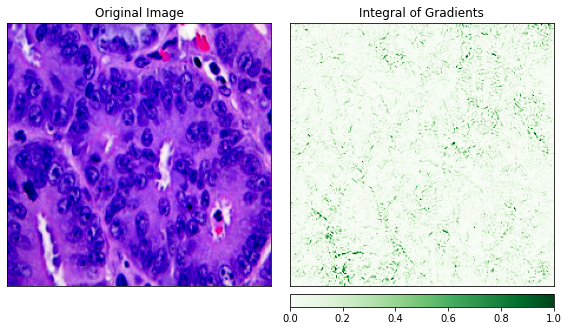

In [33]:
data_iter = iter(data_loaders["eval"])
images, labels = data_iter.next()

idx = 10
input = images[idx].unsqueeze(0).to(device)
label = labels[idx].to(device)


# Sets model to eval mode for interpretation purposes
model.eval()
outputs = model(input)
pred_score, pred_label_idx = torch.topk(outputs, 1)
pred_label_idx.squeeze_()

ig = IntegratedGradients(model)
attr_ig = ig.attribute(
    input,
    target = pred_label_idx,
    n_steps = 200
)

print(f"Ground Truth: {classes[label]}")
print(f"Prediction: {classes[pred_label_idx.item()]}, with Score: {pred_score.item():.4f}\n")

_ = viz.visualize_image_attr_multiple(
    np.transpose(attr_ig.squeeze().cpu().detach().numpy(), (1,2,0)),
    np.transpose(input.squeeze().cpu().detach().numpy(), (1,2,0)),
    methods = ["original_image", "heat_map"],
    signs = ["all", "positive"],
    show_colorbar = True,
    titles = ["Original Image", "Integral of Gradients"]
)